# Notebook 2A. Recurrent Neural Networks (RNN)
---
Organized and prepared by Christopher Monterola, updated by Kenneth Co.

This notebook was conceptualized, organized, and primarily prepared for the **Machine Learning** courses.

### This notebook uses the following references:
1. Python Machine Learning, Second Edition, Sebastian Raschka and Vahid Mirjalili, Packt Publishing Ltd. Birmingham B3 2PB, UK Sept 2017.
2. Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurélien Géron, O'Reilly 2017.
3. Deep Learning with Python, Francois Chollet, Manning New York 2018.
4. ChatGPT 4

---
In this notebook, we will explore Recurrent Neural Networks (RNNs) and see their application in modeling sequential data and a specific subset of sequential data—time-series data.  In particularwe will cover here the following topics:
- Introducing sequential data   
- RNNs for modeling sequences   
- Long Short-Term Memory (LSTM)      
    
We demonstrate the application of the RNN using **Sentiment analysis/prediction of the IMDb movie review dataset.** In **Notebook 2B**, we will look at the efficacy of using RNN for time series forecasting.

## Google Colab Setup

In [2]:
import torch
import tensorflow as tf

# Check PyTorch CUDA Version
print("PyTorch CUDA Version:")
try:
    print(torch.version.cuda)
except AttributeError:
    print("CUDA not available with this PyTorch installation.")

# Check TensorFlow CUDA Version
print("\nTensorFlow CUDA Version:")
try:
    print(tf.sysconfig.get_build_info()['cuda_version'])
except KeyError:
    print("CUDA not used in this TensorFlow build.")

# Additional checks for GPU availability
print("\nGPU Availability:")
print("PyTorch CUDA Availability:", torch.cuda.is_available())
print("TensorFlow GPU Devices:", len(tf.config.list_physical_devices('GPU')) > 0)

PyTorch CUDA Version:
None

TensorFlow CUDA Version:
CUDA not used in this TensorFlow build.

GPU Availability:
PyTorch CUDA Availability: False
TensorFlow GPU Devices: True


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/data/'
# IMG_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/images/'
# MODEL_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/'

DATA_DIR = 'data/'
IMG_DIR = 'images/'
MODEL_DIR = 'models/'

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2025-04-28 09:29:49.456430: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-28 09:29:49.456467: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-28 09:29:49.456475: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-04-28 09:29:49.456515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-28 09:29:49.456526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 1. Introducing sequential data
---

Let's begin our discussion of RNNs by looking at the nature of sequential data, more commonly known as sequences. We'll take a look at the unique properties of sequences that make them different from other kinds of data. We'll then see how we can represent sequential data, and explore the various categories of models for sequential data, which are based on the input and output of a model. This will help us explore the relationship between RNNs and sequences a little bit later on in the notebook.

### 1.1 Modeling sequential data – order matters

What makes sequences unique, from other data types, is that elements in a sequence appear in a certain order, and are not independent of each other --- in other words, order matters. We next need to find ways to leverage this valuable information in our machine learning model.

Throughout this notebook, we will represent sequences as ($x^{(1)}$ , $x^{(2)}$ , ... , $x^{(T)}$). The  superscript indices indicate the order of the instances, and the length of the sequence is T. For a sensible example of sequences, consider time-series data, where each sample point $x^{(t)}$ belongs to a particular time t.

The following figure shows an example of time-series data where both x's and y's naturally follow the order according to their time axis; therefore, both x's and y's are sequences:


<img width="761" alt="RNN_sequence" src="https://user-images.githubusercontent.com/25600601/142829757-f1f8a17d-61ce-4f70-a7f2-353ab6084037.png">

The standard neural network models that we have covered so far, such as MLPs and CNNs, are not desinged in handling the order of input samples. Intuitively, one can say that such models do not have a memory of the past seen samples. For instance, the samples are passed through the feedforward and backpropagation steps, and the
weights are updated independent of the order in which the sample is processed.

RNNs, by contrast, are designed for modeling sequences and are capable of remembering past information and processing new events accordingly.




### 1.2 The different categories of sequence modeling

Sequence modeling has many fascinating applications, such as language translation (perhaps from English to Filipino), image captioning, and text generation.

However, we need to understand the different types of sequence modeling tasks to develop an appropriate model. The following figure, based on the explanations in the excellent article The Unreasonable Effectiveness of Recurrent Neural Networks by Andrej Karpathy (http://karpathy.github.io/2015/05/21/rnn-effectiveness/), shows several different relationship categories of input and output data:

<img width="716" alt="RNN_categories" src="https://user-images.githubusercontent.com/25600601/142829866-6c30b056-42a0-4409-806c-0ec355f0f310.png">

So, let's consider the input and output data here. If neither the input or output data represents sequences, then we are dealing with standard data, and we can use any of the previous methods to model such data. But if either the input or output is a sequence, the data will form one of the following three different categories:
- **Many-to-one:** The input data is a sequence, but the output is a fixed-size vector, not a sequence. For example, in sentiment analysis, the input is textbased and the output is a class label.
- **One-to-many:** The input data is in standard format, not a sequence, but the output is a sequence. An example of this category is image captioning—the input is an image; the output is an English phrase.
- **Many-to-many:** Both the input and output arrays are sequences. This category can be further divided based on whether the input and output are synchronized or not. An example of a synchronized many-to-many modeling task is video classification, where each frame in a video is labeled. An example of a delayed many-to-many would be translating a language into another. For instance, an entire English sentence must be read and processed by a machine before producing its translation into Filipino.

# 2 RNNs for modeling sequences
---

We now look at the foundations of RNNs. We'll start by introducing the typical structure of an RNN, and we'll see how the data flows through it with one or more hidden layers. We'll then examine how the neuron activations are computed in a typical RNN. This will create a context for us to discuss the common challenges in training RNNs, and explore the modern solution to these challenges—LSTM.



### 2.1 Understanding the structure and flow of an RNN

Let's start by introducing the architecture of an RNN. The following figure shows a standard feedforward neural network and an RNN, in a side by side for comparison:

<img width="869" alt="RNNvsfeedforwardNN" src="https://user-images.githubusercontent.com/25600601/142830255-11b5251c-091e-4487-beb0-68dfc904e75a.png">

Both of these networks have only one hidden layer. In this representation, the units are not displayed, but we assume that the input layer ($\mathbf{x}$), hidden layer ($\mathbf{h}$), and output layer ($\mathbf{y}$) are vectors which contain many units.

In a standard feedforward network, information flows from the input to the hidden layer, and then from the hidden layer to the output layer. On the other hand, in a recurrent network, the hidden layer gets its input from both the input layer and the hidden layer from the previous time step.

The flow of information in adjacent time steps in the hidden layer allows the network to have a memory of past events. This flow of information is usually displayed as a loop, also known as a recurrent edge in graph notation, which is how this general architecture got its name.

In the following figure, the single hidden layer network and the multilayer network illustrate two contrasting architectures:

<img width="718" alt="RNN_architectures" src="https://user-images.githubusercontent.com/25600601/142830328-445ed659-b79e-4231-b4cc-7653ccb5b406.png">

In order to examine the architecture of RNNs and the flow of information, a compact representation with a recurrent edge can be unfolded, which you can see in the preceding figure. As we know, each hidden unit in a standard neural network receives only one input—the net preactivation associated with the input layer. Now, in contrast, each hidden unit in an RNN receives two distinct sets of input—the preactivation from the input layer and the activation of the same hidden layer from the previous time step t-1.

At the first time step t = 0, the hidden units are initialized to zeros or small random values. Then, at a time step where t > 0, the hidden units get their input from the data point at the current time $\mathbf{x}^{(t)}$ and the previous values of hidden units at t - 1, indicated as $\mathbf{h}^{(t-1)}$.

Similarly, in the case of a multilayer RNN, we can summarize the information flow as follows:

• *layer =1*: Here, the hidden layer is represented as $\mathbf{h_1}^{(t)}$ and gets its input
from the data point $\mathbf{x}^{(t)}$ and the hidden values in the same layer, but the previous time step $\mathbf{h_1}^{(t-1)}$

• *layer = 2* : The second hidden layer, $\mathbf{h_2}^{(t)}$ receives its inputs from the hidden units from the layer below at the current time step $\mathbf{h_1}^{(t)}$ and its own hidden values from the previous time step $\mathbf{h_2}^{(t-1)}$



### 2.2 Computing activations in an RNN

Now that we understand the structure and general flow of information in an RNN, let's get more specific and compute the actual activations of the hidden layers as well as the output layer. For simplicity, we'll consider just a single hidden layer; however, the same concept applies to multilayer RNNs.

Each directed edge (the connections between boxes) in the representation of an RNN that we just looked at is associated with a weight matrix. Those weights do not depend on time t; therefore, they are shared across the time axis. The different weight matrices in a single layer RNN are as follows:

• $\mathbf{W}_{xh}$ : The weight matrix between the input $\mathbf{x}^{(t)}$ and the hidden layer $\mathbf{h}$   
• $\mathbf{W}_{hh}$ : The weight matrix associated with the recurrent edge   
• $\mathbf{W}_{hy}$: The weight matrix between the hidden layer and output layer   

You can see these weight matrices in the following figure:

<img width="877" alt="RNN_weightmatrices" src="https://user-images.githubusercontent.com/25600601/142830555-fe261213-9fcd-416d-a0c7-cfc12af74f86.png">

In certain implementations, you may observe that weight matrices $\mathbf{W}_{xh}$ and $\mathbf{W}_{hh}$ are concatenated to a combined matrix $\mathbf{W}_{h}$ = [$\mathbf{W}_{xh}$; $\mathbf{W}_{hh}$]. Later on, we'll make use of this notation as well.


Computing the activations is very similar to standard multilayer perceptrons and other types of feedforward neural networks. For the hidden layer, the net input $\mathbf{z}_h$(preactivation) is computed through a linear combination. That is, we compute the sum of the multiplications of the weight matrices with the corresponding vectors and add the bias unit --- $\mathbf{z}_h$=$\mathbf{W}_{xh}$$\mathbf{x}^{(t)}$ + $\mathbf{W}_{hh}$$\mathbf{h}^{(t-1)}$ + $\mathbf{b}_{h}$. Then, the activations of the hidden units at the time step t are calculated as follows:

\begin{equation}
\mathbf{h}^{(t)}= \phi_h(\mathbf{z}_h) = \phi_h(\mathbf{W}_{xh} \mathbf{x}^{(t)} + \mathbf{W}_{hh} \mathbf{h}^{(t-1)} + \mathbf{b}_{h})
\end{equation}

Here, $\mathbf{b}_{h}$ is the bias vector for the hidden units and $\phi_h( )$  is the activation function
of the hidden layer.



In case you want to use the concatenated weight matrix $\mathbf{W}_{h}$ = [$\mathbf{W}_{xh}$; $\mathbf{W}_{hh}$], the formula for computing hidden units will change as follows:

\begin{equation}
\mathbf{h}^{(t)}= \phi_h(\mathbf{W}_{h}\begin{bmatrix}\mathbf{x}^{(t)}\\
\mathbf{h}^{(t-1)} \\
\end{bmatrix} + \mathbf{b}_{h})
\end{equation}


Once the activations of hidden units at the current time step are computed, then the activations of output units will be computed as follows:

\begin{equation}
\mathbf{y}^{(t)}= \phi_y(\mathbf{W}_{hy}\mathbf{h}^{(t)} + \mathbf{b}_{y})
\end{equation}

To help clarify this further, the following figure shows the process of computing
these activations with both formulations:

<img width="869" alt="RNNvsfeedforwardNN" src="https://user-images.githubusercontent.com/25600601/142830623-5affd7c0-6240-4f0f-b829-f3446eb3a751.png">


Backpropagation now proceeds as usual as we have not a clear expresssion for weights and output of the RNN.


### 2.3 The challenges of learning long-range interactions

<img width="709" alt="RNN_BPTT" src="https://user-images.githubusercontent.com/25600601/142831664-4882c954-55b5-45f6-9bc1-da05889f2363.png">

Backpropagation through time, or BPTT, which we briefly mentioned in the previous
information box, introduces some new challenges. Because of the multiplicative factor $\frac{\partial \mathbf{h}^{(t)}}{\partial \mathbf{h}^{(k)}}$ in the computing gradients of a loss function, the so-called vanishing or exploding gradient problem arises. This problem is explained through the examples in the following figure, which shows an RNN with only one hidden unit for simplicity:

<img width="869" alt="RNN_gradients" src="https://user-images.githubusercontent.com/25600601/142831742-9324ea36-9a4c-46e4-ab18-a30ba49b0e0e.png">

Basically, $\frac{\partial \mathbf{h}^{(t)}}{\partial \mathbf{h}^{(k)}}$ has t − k multiplications; therefore, multiplying the $w$ weight t − k times results in a factor — $w^{t−k}$. As a result, if $w$ <1, this factor becomes very small when t − k is large. On the other hand, if the weight of the recurrent edge is w >1,
then $w^{t−k}$ becomes very large when t − k is large. Note that large t − k refers to longrange dependencies.

Intuitively, we can see that a naive solution to avoid vanishing or exploding gradient can be accomplished by ensuring $|w|=1$. If you are interested and would like to investigate this in more detail, I encourage you to read *On the difficulty of training recurrent neural networks by R. Pascanu, T. Mikolov, and Y. Bengio, 2012 (https://
arxiv.org/pdf/1211.5063.pdf).*

In practice, there are two solutions to this problem:

• Truncated backpropagation through time (TBPTT)  
• Long short-term memory (LSTM)  

TBPTT clips the gradients above a given threshold. While TBPTT can solve the exploding gradient problem, the truncation limits the number of steps that the gradient can effectively flow back and properly update the weights.

On the other hand, LSTM, designed in 1997 by Hochreiter and Schmidhuber, has been more successful in modeling long-range sequences by overcoming the vanishing gradient problem. Let's discuss LSTM in more detail in the next section.

Number of parameters: num_units* num_units + num_features* num_units + biases


# Example 1A. Sentiment analysis of IMDb movie reviews using a simple RNN
We will implement a multilayer RNN for sentiment analysis using a many-to-one architecture.

Here is a typical IMDb review for Fantastic Beasts: The Crimes of Grindelwald (https://www.imdb.com/title/tt4123430/reviews?ref_=tt_urv)

**Negative review**: Basically everything wrong with the movie can be summed up with its title. Fantastic Beasts. The Crimes of Grindelwald. These two things have nothing to do with each other. In my opinion the faults of this movie date back to the first film, where we had the compelling story of a young wizard named David Attenborough whose animals escaped in New York and he had to find them. Great. Sold. Unfortunately they had to make the film much worse by adding in unnecessary and convoluted subplots about a repressed boy named Credence who could change into a dangerous obscuris. Or something. The filmmakers obviously didn't learn from their mistakes.

**Positive review**: As a huge fan of the first Fantastic Beasts film, I had been looking forward to this film for a while. I'm so glad that it didn't disappoint! I really enjoyed this movie, just as much as the first installment. Of course, it is a bit different, and it gets down to serious business, so the tone is a bit darker. Which of course makes sense. There was still enough humor though, and I love the characters. The storyline is great, the villain is interesting, the special effects were amazing, and the history and lore for the Harry Potter series is rich and enjoyable. Although this movie is pretty amazing, it did suffer from trying to feed us a lot of information and history. Yeah, there is a lot to take in, and a lot you find out. Perhaps this movie could've been a bit longer too as some extra scenes between some characters would've been appreciated. But with all of the information and history that was given, I found it all to be pretty exciting. I definitely feel as if this is a definite must see for any Harry Potter fan.

### Step 1. Prepare the IMDb dataset
Update data can be downloaded here: https://www.kaggle.com/utathya/imdb-review-dataset but for illustration let's use the one available in Keras.

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from keras.datasets import imdb
from keras.preprocessing import sequence

# Set parameters similar to the original Keras setup
max_features = 10000
maxlen = 500
BATCH_SIZE = 128

# Load IMDB dataset
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

# Pad sequences
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# Convert numpy arrays to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float)

# Custom Dataset
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
train_dataset = IMDBDataset(x_train, y_train)
test_dataset = IMDBDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


Below is the detailed description of each line in the above code that will be fed for sentiment analysis using a Recurrent Neural Network (RNN) with the Keras library:

1. **Import Libraries**
   - `from keras.datasets import imdb`: Import the IMDB dataset module from Keras.
   - `from keras.preprocessing import sequence`: Import sequence preprocessing utilities.

2. **Define Parameters**
   - `max_features = 10000`: Define the maximum number of most frequent words to keep in the vocabulary.
   - `maxlen = 500`: Set the maximum sequence length. Longer texts will be truncated.
   - `batch_size = 32`: Specify the batch size for the model.

3. **Load Data**
   - `print('Loading data...')`: Print a message indicating the start of data loading.
   - Load the dataset, splitting into training and testing sets: `(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)`

4. **Output Dataset Sizes**
   - `print(len(input_train), 'train sequences')`: Print the number of training sequences.
   - `print(len(input_test), 'test sequences')`: Print the number of test sequences.

5. **Prepare Data**
   - `print('Pad sequences (samples x time)')`: Notify that sequences will be padded to a uniform length.
   - `input_train = sequence.pad_sequences(input_train, maxlen=maxlen)`: Pad/truncate the training sequences.
   - `input_test = sequence.pad_sequences(input_test, maxlen=maxlen)`: Pad/truncate the test sequences.

6. **Display Data Shape**
   - `print('input_train shape:', input_train.shape)`: Print the shape of the training data.
   - `print('input_test shape:', input_test.shape)`: Print the shape of the test data.

This setup prepares and processes the IMDB dataset for sentiment analysis, ensuring each input sequence is uniform for model training and evaluation.

### Step 2. Train the model with Embedding and SimpleRNN layers

In [6]:
from torchinfo import summary

# Define the model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        # Taking the output from the last time step
        output = self.fc(output[:, -1, :])
        return self.sigmoid(output)

# Initialize the model
model = RNNModel(vocab_size=max_features, embedding_dim=32, hidden_dim=32)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Correct input size for torchinfo.summary
# The input must be of type Long or Int for the Embedding layer
summary(model, input_size=(BATCH_SIZE, maxlen), dtypes=[torch.long], device=device)

cpu


Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [128, 1]                  --
├─Embedding: 1-1                         [128, 500, 32]            320,000
├─RNN: 1-2                               [128, 500, 32]            2,112
├─Linear: 1-3                            [128, 1]                  33
├─Sigmoid: 1-4                           [128, 1]                  --
Total params: 322,145
Trainable params: 322,145
Non-trainable params: 0
Total mult-adds (M): 176.13
Input size (MB): 0.51
Forward/backward pass size (MB): 32.77
Params size (MB): 1.29
Estimated Total Size (MB): 34.57

### Parameter Calculation

The following breakdown explains how the total parameters for each layer in the given Keras model are derived:

#### 1. Embedding Layer
- **Formula**: `output_dim * input_dim`
- **Explanation**: The `Embedding` layer is designed to transform words into dense vectors of a fixed size. Here, `max_features` represents the `input_dim`, i.e., the size of the vocabulary, and `32` is the `output_dim`, the size of the vector space in which words will be embedded.
- **Calculation**: Assuming `max_features` is 10,000, the total number of parameters is `10,000 * 32 = 320,000`. Each word in the vocabulary has a unique 32-dimensional vector.

#### 2. SimpleRNN Layer
- **Formula**: `(input_size + units) * units + units` (includes bias)
- **Explanation**: The `SimpleRNN` layer processes sequence data with recurrent connections. In the formula:
  - `input_size` is 32, the output dimension from the `Embedding` layer.
  - `units` is 32, representing the number of units in the RNN.
- **Calculation**: The total parameters are `(32 + 32) * 32 + 32 = 2080`. This count includes weights for the inputs, weights for the recurrent connections, and biases.

#### 3. Dense Layer
- **Formula**: `(input_units * output_units) + output_units`
- **Explanation**: This layer is a fully connected (dense) neural network layer where every input is connected to every output.
- **Calculation**: Inputs from the `SimpleRNN` layer are 32 units, reduced to 1 unit with a `sigmoid` activation. Thus, the parameters are `32 * 1 + 1 = 33`.

#### Summary of Parameters
- **Embedding Layer**: 320,000 parameters
- **SimpleRNN Layer**: 2,080 parameters
- **Dense Layer**: 33 parameters

The above formulas account for both the weights and biases that the model learns during training.


<div class="alert alert-block alert-info">

#### ⚠️ Checkpoint ⚠️

In the next 5 minutes, make sure everyone in your LT understands the number of parameters and why that is used.
</div>

In [7]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters())

# Initialize lists to store statistics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_x, batch_y in train_loader:
        # Forward pass
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track training statistics
        train_loss += loss.item() * batch_x.size(0)
        train_total += batch_y.size(0)
        train_correct += ((outputs.squeeze() > 0.5) == batch_y).sum().item()
    
    # Calculate training stats
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            val_loss += criterion(outputs.squeeze(), batch_y).item() * batch_x.size(0)
            val_total += batch_y.size(0)
            val_correct += ((outputs.squeeze() > 0.5) == batch_y).sum().item()
    
    # Calculate validation stats
    val_loss /= len(test_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Epoch [1/10], Train Loss: 0.6907, Train Acc: 53.67%, Val Loss: 0.6690, Val Acc: 58.31%
Epoch [2/10], Train Loss: 0.6174, Train Acc: 64.84%, Val Loss: 0.6048, Val Acc: 66.72%
Epoch [3/10], Train Loss: 0.5404, Train Acc: 72.66%, Val Loss: 0.5711, Val Acc: 71.10%
Epoch [4/10], Train Loss: 0.4916, Train Acc: 76.30%, Val Loss: 0.5546, Val Acc: 73.04%
Epoch [5/10], Train Loss: 0.4511, Train Acc: 79.02%, Val Loss: 0.5530, Val Acc: 73.51%
Epoch [6/10], Train Loss: 0.4138, Train Acc: 81.86%, Val Loss: 0.5579, Val Acc: 74.04%
Epoch [7/10], Train Loss: 0.3861, Train Acc: 83.24%, Val Loss: 0.5908, Val Acc: 73.91%
Epoch [8/10], Train Loss: 0.4370, Train Acc: 80.58%, Val Loss: 0.5808, Val Acc: 74.19%
Epoch [9/10], Train Loss: 0.4079, Train Acc: 82.22%, Val Loss: 0.5732, Val Acc: 76.01%
Epoch [10/10], Train Loss: 0.3971, Train Acc: 82.31%, Val Loss: 0.5831, Val Acc: 74.50%


### Step 3.  Save the Model

In [8]:
import torch
# Assuming 'model' is your PyTorch model
torch.save(model.state_dict(), MODEL_DIR + "simpleRNN_500.pth")
print("Saved model to disk")

Saved model to disk


### Step 4. Plotting results

Now, let’s display the training and validation loss and accuracy

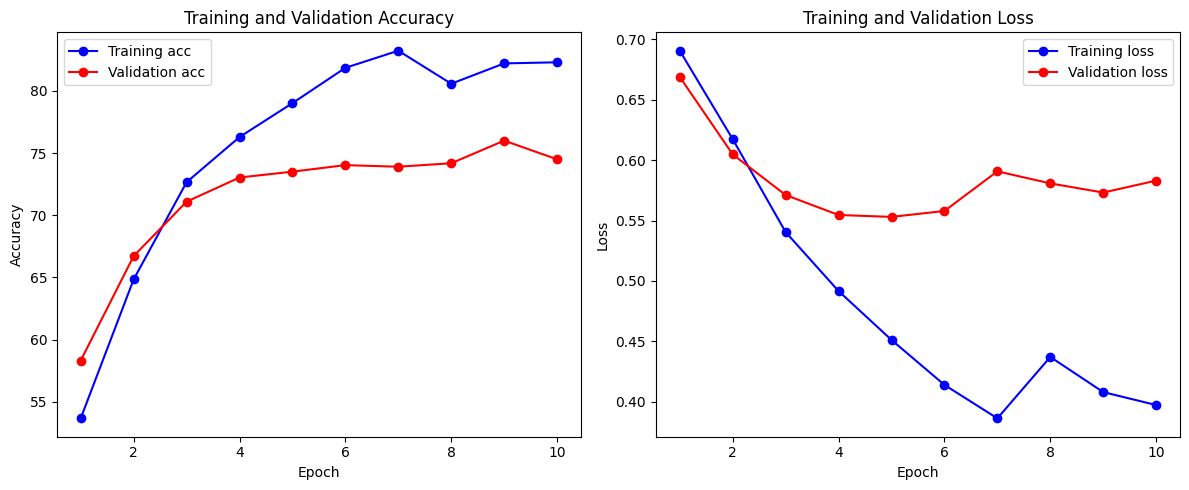

In [9]:
import matplotlib.pyplot as plt
# After training is done, plot the statistics
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'bo-', label='Training acc')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Note that we have only considered the first 500 words, rather than full sequences and we obtain only an accuracy of $74\%$. Now let's implement a more advanced RNN, say LSTM.


### Step 5. Loading and testing saved model

In [10]:
import keras

INDEX_FROM=3   # word index offset
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
import numpy as np
import torch
from keras.preprocessing.sequence import pad_sequences

# Assuming 'model' is your PyTorch model and 'word_to_id' is your vocabulary mapping
max_review_length = 500
bad = "this movie was bad and terrible i almost die"
good = "not bad"
neutral = "it was good"
vague = "it was great"

for review in [bad, good, neutral, vague]:
    tmp = []
    for word in review.split(" "):
        # Ensure the word exists in your vocabulary to avoid KeyError
        if word in word_to_id:
            tmp.append(word_to_id[word])
    
    tmp_padded = pad_sequences([tmp], maxlen=max_review_length)
    tensor_input = torch.tensor(tmp_padded).to(device).long()  # Ensure the tensor is of long type for embedding

    with torch.no_grad():
        sentiment = model(tensor_input)[0][0]
        print(f"{review}. Sentiment: {sentiment}")

this movie was bad and terrible i almost die. Sentiment: 0.01526348665356636
not bad. Sentiment: 0.02043193206191063
it was good. Sentiment: 0.49197104573249817
it was great. Sentiment: 0.6722190380096436


# 3. Long short-term memory (LSTM)
---
LSTMs were first introduced to overcome the vanishing gradient problem (Long Short-Term Memory, S. Hochreiter and J. Schmidhuber, Neural Computation, 9(8): 1735-1780, 1997). The building block of an LSTM is a memory cell, which
essentially represents the hidden layer.

First recall that the simple RNN is given by the schematics below:

<img width="673" alt="RNN_simple" src="https://user-images.githubusercontent.com/25600601/142830937-1f49a738-ba3b-4938-9d11-24638f7448c7.png">

In each memory cell, there is a recurrent edge that has the desirable weight w =1, as we discussed previously, to overcome the vanishing and exploding gradient problems. The values associated with this recurrent edge is called cell state. The unfolded structure of a modern LSTM cell is shown in the following figure:

<img width="1021" alt="RNN_LSTM" src="https://user-images.githubusercontent.com/25600601/142831002-2544020d-36e3-4976-b0d1-7fc8fc4f0cdb.png">

Notice that the cell state from the previous time step, $\mathbf{C}^{(t−1)}$, is modified to get the cell
state at the current time step,  $\mathbf{C}^{(t)}$ , without being multiplied directly with any weight
factor. For comparison, here is how the simple RNN is changed by LSTM:

<img width="701" alt="RNN_LSTM2" src="https://user-images.githubusercontent.com/25600601/142831098-289119a4-8331-4cde-a823-5493354ccd1d.png">

The flow of information in this memory cell is controlled by some units of computation that we'll describe here. In the previous figure, $\odot$ refers to the element-wise product (element-wise multiplication) and means $\oplus$ element-wise summation (element-wise addition). Furthermore, $\mathbf{x}^{(t)}$ refers to the input data at time t, and $\mathbf{h}^{(t−1)}$ indicates the hidden units at time t −1.

Four boxes are indicated with an activation function, either the sigmoid function ($\sigma$) or hyperbolic tangent ($\tanh$), and a set of weights; these boxes apply linear combination by performing matrix-vector multiplications on their input. These units of computation with sigmoid activation functions, whose output units are passed through $\odot$, are called **gates**.

In an LSTM cell, there are three different types of gates, known as the forget gate, the
input gate, and the output gate:

• The **forget gate** ($\mathbf{f}_t$) allows the memory cell to reset the cell state without growing indefinitely. In fact, the forget gate decides which information is allowed to go through and which information to suppress. Now, $\mathbf{f}_t$ is computed as follows:

\begin{equation}
\mathbf{f}_{t}= \sigma(\mathbf{W}_{xf}\mathbf{x}^{(t)} + \mathbf{W}_{hf}\mathbf{h}^{(t-1)} + \mathbf{b}_{f})
\end{equation}

Note that the forget gate was not part of the original LSTM cell; it was added a few years later to improve the original model (*Learning to Forget: Continual Prediction with LSTM, F. Gers, J. Schmidhuber, and F. Cummins, Neural Computation 12, 2451-2471, 2000*).

• The **input gate** ($\mathbf{i}_t$) and **input node** ( $\mathbf{g}_t$ ) are responsible for updating the cell
state. They are computed as follows:

\begin{equation}
\mathbf{i}_{t}= \sigma(\mathbf{W}_{xi}\mathbf{x}^{(t)} + \mathbf{W}_{hi}\mathbf{h}^{(t-1)} + \mathbf{b}_{i})
\end{equation}

\begin{equation}
\mathbf{g}_{t}= \tanh(\mathbf{W}_{xg}\mathbf{x}^{(t)} + \mathbf{W}_{hg}\mathbf{h}^{(t-1)} + \mathbf{b}_{g})
\end{equation}

The cell state at time t is computed as follows:

\begin{equation}
\mathbf{C}^{t}= (\mathbf{C}^{t-1} \odot \mathbf{f}_{t}) \oplus (\mathbf{i}_{t} \odot \mathbf{g}_{t})
\end{equation}

The output gate ($\mathbf{o}_t$ ) decides how to update the values of hidden units:

\begin{equation}
\mathbf{o}_{t}= \sigma(\mathbf{W}_{xo}\mathbf{x}^{(t)} + \mathbf{W}_{ho}\mathbf{h}^{(t-1)} \mathbf{b}_{o})
\end{equation}


Given this, the hidden units at the current time step are computed as follows:

\begin{equation}
\mathbf{h}_{t}= \mathbf{o}_{t} \odot \tanh(\mathbf{C}^{t})
\end{equation}

The structure of an LSTM cell and its underlying computations might seem too complex. However, the good news is that TensorFlow has already implemented everything in wrapper functions that allows us to define our LSTM cells easily.

NOTE: The LSTM introduced here provides a basic approach for modeling long-range dependencies in sequences.
Yet, it is important to note that there are many variations of LSTMs described in literature (An Empirical Exploration of Recurrent Network Architectures, Rafal Jozefowicz, Wojciech Zaremba, and Ilya Sutskever,
Proceedings of ICML, 2342-2350, 2015). Also, worth noting is a more recent approach, called Gated Recurrent Unit (GRU), which was proposed in 2014. GRUs have a simpler architecture than LSTMs; therefore, they are computationally more efficient while their performance in some tasks, such as polyphonic music modeling, is comparable to LSTMs. If you are interested in learning more about these modern RNN architectures, refer to the paper, Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling by Junyoung Chung
and others 2014 (https://arxiv.org/pdf/1412.3555v1.pdf). Implementation of such can be an individual project.

*Intuitive idea from Chollet:  The Carry layer $C$ intends to add a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.*

If you want to get philosophical, you can interpret what each of these operations is meant to do. For instance, you can say that multiplying $\mathbf{C}^{(t)}$ and $\mathbf{f}_{(t)}$ is a way to deliberately forget irrelevant information in the carry dataflow. Meanwhile, $\mathbf{i}_{(t)}$ and $\mathbf{g}_{(t)}$ provide information about the present, updating the carry track with new information.

But at the end of the day, these interpretations don’t mean much, because what these operations actually do is determined by the contents of the weights parameterizing them; and the weights are learned in an end-to-end fashion, starting over with each training round, making it impossible to credit this or that operation with a specific purpose. The specification of an RNN cell (as just described) determines your hypothesis
space—the space in which you’ll search for a good model configuration during training—but it doesn’t determine what the cell does; that is up to the cell weights.

The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of constraints on your search, not as a design in an engineering sense.

To a researcher, it seems that the choice of such constraints—the question of how to implement RNN cells—is better left to optimization algorithms (like genetic algorithms or reinforcement learning processes) than to human engineers. And in the future, that’s how we’ll build networks.

<div class="alert alert-block alert-success">
Keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.
</div>

# Example 1B. Sentiment analysis of IMDb movie reviews using a simple LSTM

We will implement a multilayer RNN for sentiment analysis using a many-to-one architecture.

### Step 1. Data Preparation
Already done above.

### Step 2. Using LSTM

In [12]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return self.sigmoid(output)

embedding_dim = 32
hidden_dim = 32

model = LSTMModel(vocab_size=max_features, embedding_dim=embedding_dim, hidden_dim=hidden_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cpu


In [13]:
from torchinfo import summary
summary(model, input_size=(32, 100), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 1]                   --
├─Embedding: 1-1                         [32, 100, 32]             320,000
├─LSTM: 1-2                              [32, 100, 32]             8,448
├─Linear: 1-3                            [32, 1]                   33
├─Sigmoid: 1-4                           [32, 1]                   --
Total params: 328,481
Trainable params: 328,481
Non-trainable params: 0
Total mult-adds (M): 37.27
Input size (MB): 0.03
Forward/backward pass size (MB): 1.64
Params size (MB): 1.31
Estimated Total Size (MB): 2.98

In [14]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters())

# Initialize lists to store statistics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
NUM_EPOCHS = 6

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_x, batch_y in train_loader:
        # Forward pass
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track training statistics
        train_loss += loss.item() * batch_x.size(0)
        train_total += batch_y.size(0)
        train_correct += ((outputs.squeeze() > 0.5) == batch_y).sum().item()
    
    # Calculate training stats
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            val_loss += criterion(outputs.squeeze(), batch_y).item() * batch_x.size(0)
            val_total += batch_y.size(0)
            val_correct += ((outputs.squeeze() > 0.5) == batch_y).sum().item()
    
    # Calculate validation stats
    val_loss /= len(test_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch [1/6], Train Loss: 0.5613, Train Acc: 70.32%, Val Loss: 0.4278, Val Acc: 81.18%
Epoch [2/6], Train Loss: 0.3782, Train Acc: 83.74%, Val Loss: 0.3635, Val Acc: 84.53%
Epoch [3/6], Train Loss: 0.2868, Train Acc: 88.52%, Val Loss: 0.3566, Val Acc: 84.50%
Epoch [4/6], Train Loss: 0.2199, Train Acc: 91.66%, Val Loss: 0.4228, Val Acc: 82.67%
Epoch [5/6], Train Loss: 0.1758, Train Acc: 93.45%, Val Loss: 0.3941, Val Acc: 85.38%
Epoch [6/6], Train Loss: 0.1391, Train Acc: 95.11%, Val Loss: 0.3797, Val Acc: 86.64%


### Step 3. Save the Model

In [15]:
torch.save(model.state_dict(), MODEL_DIR + "LSTM_500.pth")
print("Saved model to disk")

Saved model to disk


### Step 4. Plot the result accuracy for visual appreciation.

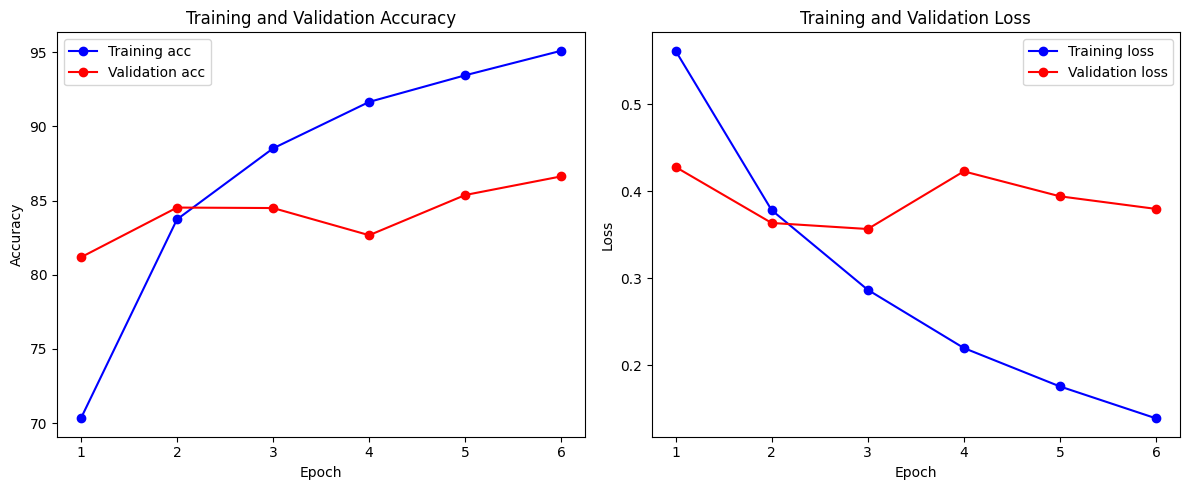

In [16]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'bo-', label='Training acc')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

This time, you achieve up to 88.3% validation accuracy. That's not bad; better than the SimpleRNN network. That’s largely because LSTM suffers much less from the vanishing-gradient problem.

But this result isn’t groundbreaking for such a computationally intensive approach. Why isn’t LSTM performing better? One reason is that you made no effort to tune hyperparameters such as the embeddings dimensionality or the LSTM output dimensionality. Another may be lack of regularization. But honestly, the primary reasons that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. That’s what the first fully connected approach looked at. But there are far more difficult natural language- processing problems out there, where the strength of LSTM will become apparent: in particular, **question-answering** and **machine translation.**

### Step 5. Loading and testing saved model

In [17]:
model = LSTMModel(vocab_size=max_features, embedding_dim=32, hidden_dim=32)
state_dict = torch.load(MODEL_DIR + "LSTM_500.pth", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

LSTMModel(
  (embedding): Embedding(10000, 32)
  (lstm): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
from keras.preprocessing.sequence import pad_sequences

max_review_length = 50
reviews = [
    "this movie was bad and terrible i almost die not brilliant it is really terrible and brilliant",
    "not brilliant",
    "it is really terrible and brilliant",
    "somewhere somehow"
]

for review in reviews:
    tmp = []
    for word in review.split(" "):
        if word in word_to_id:  # To handle out-of-vocabulary words
            tmp.append(word_to_id[word])
    
    # Pad the sequence
    tmp_padded = pad_sequences([tmp], maxlen=max_review_length, padding='post', truncating='post')
    tensor_input = torch.tensor(tmp_padded).long()
    
    with torch.no_grad():
        sentiment = model(tensor_input).item()
        print(f"{review}. Sentiment: {sentiment}")

this movie was bad and terrible i almost die not brilliant it is really terrible and brilliant. Sentiment: 0.24260437488555908
not brilliant. Sentiment: 0.24259962141513824
it is really terrible and brilliant. Sentiment: 0.24259980022907257
somewhere somehow. Sentiment: 0.24259881675243378


# Example 1C. Increasing nodes
What if we increase the number of nodes of the embedding layer? Can this immediately increase the accuracy?

### Step 1. Data Preparation
Already done

### Step 2. Instantiate the model and Run. Let's just increase the embedding nodes from 32 to 64.

In [19]:
# Initialize the model with different embedding dimensions
model = RNNModel(vocab_size=max_features, embedding_dim=64, hidden_dim=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

summary(model, input_size=(BATCH_SIZE, maxlen), dtypes=[torch.long], device=device)

cpu


Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [128, 1]                  --
├─Embedding: 1-1                         [128, 500, 64]            640,000
├─RNN: 1-2                               [128, 500, 32]            3,136
├─Linear: 1-3                            [128, 1]                  33
├─Sigmoid: 1-4                           [128, 1]                  --
Total params: 643,169
Trainable params: 643,169
Non-trainable params: 0
Total mult-adds (M): 282.63
Input size (MB): 0.51
Forward/backward pass size (MB): 49.15
Params size (MB): 2.57
Estimated Total Size (MB): 52.24

In [20]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters())

# Initialize lists to store statistics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_x, batch_y in train_loader:
        # Forward pass
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track training statistics
        train_loss += loss.item() * batch_x.size(0)
        train_total += batch_y.size(0)
        train_correct += ((outputs.squeeze() > 0.5) == batch_y).sum().item()
    
    # Calculate training stats
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            val_loss += criterion(outputs.squeeze(), batch_y).item() * batch_x.size(0)
            val_total += batch_y.size(0)
            val_correct += ((outputs.squeeze() > 0.5) == batch_y).sum().item()
    
    # Calculate validation stats
    val_loss /= len(test_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Epoch [1/10], Train Loss: 0.6507, Train Acc: 61.09%, Val Loss: 0.6033, Val Acc: 68.07%
Epoch [2/10], Train Loss: 0.5487, Train Acc: 72.29%, Val Loss: 0.5863, Val Acc: 69.25%
Epoch [3/10], Train Loss: 0.5300, Train Acc: 73.24%, Val Loss: 0.5700, Val Acc: 70.36%
Epoch [4/10], Train Loss: 0.4736, Train Acc: 77.17%, Val Loss: 0.6011, Val Acc: 72.51%
Epoch [5/10], Train Loss: 0.4494, Train Acc: 79.32%, Val Loss: 0.5430, Val Acc: 73.52%
Epoch [6/10], Train Loss: 0.4354, Train Acc: 80.06%, Val Loss: 0.5949, Val Acc: 70.18%
Epoch [7/10], Train Loss: 0.4190, Train Acc: 81.16%, Val Loss: 0.5640, Val Acc: 74.12%
Epoch [8/10], Train Loss: 0.4140, Train Acc: 81.25%, Val Loss: 0.6494, Val Acc: 69.10%
Epoch [9/10], Train Loss: 0.4031, Train Acc: 81.98%, Val Loss: 0.6266, Val Acc: 70.72%
Epoch [10/10], Train Loss: 0.4091, Train Acc: 81.36%, Val Loss: 0.6193, Val Acc: 70.34%


### Step 3. Again, let's save the model.

In [21]:
import torch
# Assuming 'model' is your PyTorch model
torch.save(model.state_dict(), MODEL_DIR + "simpleRNN_64_500.pth")
print("Saved model to disk")

Saved model to disk


### Step 4. Visualization of Learning generalization.

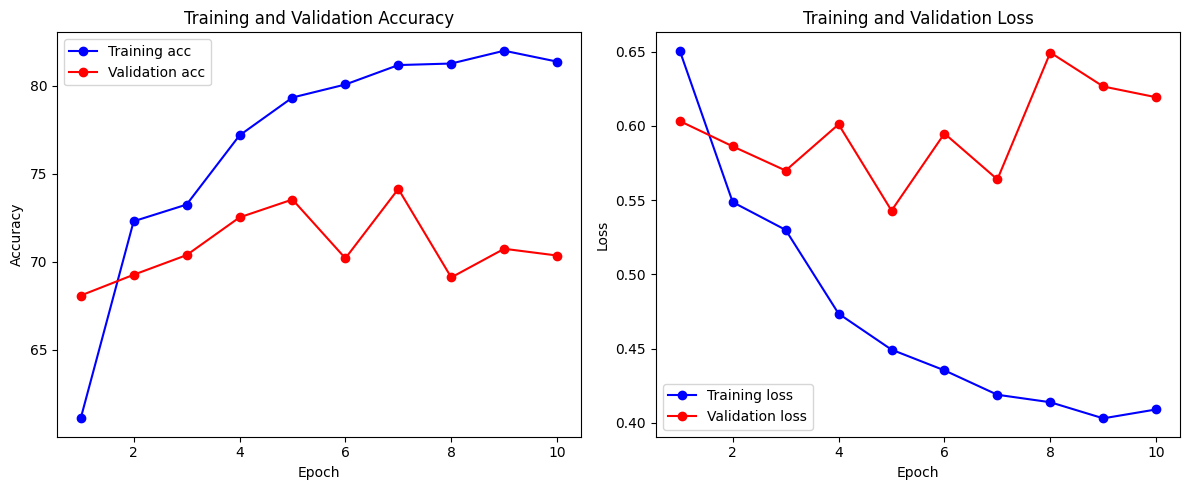

In [22]:
import matplotlib.pyplot as plt
# After training is done, plot the statistics
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'bo-', label='Training acc')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The result gives almost the same accuracy as embedding nodes of 32. The result will also not significantly increase as a result of the addition of more features (verify). The primary reason is that analyzing the global, long-term structure of the reviews isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency.

### Step 5. Loading and testing saved model

In [23]:
# Load the model
model = RNNModel(vocab_size=max_features, embedding_dim=64, hidden_dim=32)
state_dict = torch.load(MODEL_DIR + "simpleRNN_64_500.pth", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

RNNModel(
  (embedding): Embedding(10000, 64)
  (rnn): RNN(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [24]:
import keras

INDEX_FROM=3   # word index offset
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
id_to_word = {value:key for key,value in word_to_id.items()}
print("Negative review \n")
print(' '.join(id_to_word[id] for id in x_train[10].numpy()))
print("\n Positive review \n")
print(' '.join(id_to_word[id] for id in x_train[42].numpy()))

Negative review 

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a ce

In [25]:
import numpy as np

#predict sentiment from reviews
max_review_length=500
bad = "this movie was bad and terrible i almost die"
good = "brilliant movie a masterpiece"
neutral = "it is really terrible and brilliant"
vague = "somewhere somehow"

for review in [bad,good,neutral,vague]:
    tmp = []
    for word in review.split(" "):
        # Assuming 'word_to_id' is your vocabulary mapping from word to index
        if word in word_to_id:  # To handle out-of-vocabulary words
            tmp.append(word_to_id[word])
    
    # Pad the sequence
    tmp_padded = pad_sequences([tmp], maxlen=max_review_length, padding='post', truncating='post')
    tensor_input = torch.tensor(tmp_padded).long()  # Long tensor for embedding layer
    
    with torch.no_grad():  # Disable gradient calculation for inference
        sentiment = model(tensor_input).item()  # Get the scalar value
        print(f"{review}. Sentiment: {sentiment}")

this movie was bad and terrible i almost die. Sentiment: 0.9098849892616272
brilliant movie a masterpiece. Sentiment: 0.9098849892616272
it is really terrible and brilliant. Sentiment: 0.9098849892616272
somewhere somehow. Sentiment: 0.9098849892616272


<div class="alert alert-block alert-info">

# ⚠️ Checkpoint ⚠️

In the next 5-10 minutes, review the 3 main RNNs that we've gone over and compare them with each other. What are the similarities and differences with them? Make sure your LT understands.
</div>